# Genetic algorithm

## 1) Geometry & solver

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import sys, os
from ngsolve import *
from netgen.geom2d import SplineGeometry
from solverlibBESO import *
from commons.geometry import transformerCG
from commons.objective import fObjectif,dufObjectif
from ngsolve.webgui import Draw

np.random.seed(0) # fix the seed to ensure reproducibility

def Volume(mesh,binaryVariable):
    return Integrate(binaryVariable*dx,mesh)

def TotalVolume(mesh):
    return Integrate(CoefficientFunction(1)*dx(definedon=~mesh.Materials("P1|P2|S1|S2")),mesh)

def cfFromVec(vec,shape=(7,5)):
    return {f"D_{i}_{j}":vec[i+j*shape[0]] for i in range(2*shape[0]+1) for j in range(2*shape[1]+1)}

vec = np.random.randint(0,2,15*11)

# Material properties
mu0 = 4e-7 * np.pi
mur = 1000
nuiron = 1/(mu0*mur)
J = 1e6
# Meshing
mesh = transformerCG(NCoils = 2,hmax = 1e-1)
VolTot = TotalVolume(mesh)
eVol = Integrate(CoefficientFunction(1),mesh,element_wise=True).NumPy()[:]
var0Dict = {"D" : 0, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(np.random.randint(0,2,15*11))
binaryVar0 = GridFunction(L2(mesh)) ; binaryVar0.Set(CoefficientFunction([var0Dict[mat] for mat in mesh.GetMaterials()]))
Draw(mesh)
Draw(binaryVar0,mesh,"Initial Design")
displayDict = {"D" : 1, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(np.zeros(15*11))
displayCF = CoefficientFunction([displayDict[mat] for mat in mesh.GetMaterials()])
Draw(binaryVar0*displayCF,mesh,"Initial distribution")
FESolver = MagStat2D(mesh,dirichlet="out")
FESolver.set_ironBH(lambda b: nuiron)
FESolver.add_domain_tag([],[f"D_{i}_{j}" for i in range(15) for j in range(11)],['P1','P2','S1','S2'])
sourceDict = {"D" : 0, "P1" : J, "P2":-J, "S1":0 ,"S2":0}|cfFromVec(np.zeros(15*11))
jd = CoefficientFunction([sourceDict[mat] for mat in mesh.GetMaterials()])
FESolver.set_source(lambda v: jd*v)
FESolver.SolveState(binaryVar0)
FESolver.SolveAdjoint(binaryVar0,lambda *args : -1*dufObjectif(*args))
FESolver.show()
print(fObjectif(mesh,FESolver.gfu))

   

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

-1.3818263659830011e-08


## 2) Setup the GA class

In [ ]:
from tqdm import tqdm
volFracTarget = 0.1
class GA:
    def __init__(self,popSize):
        self.pMutate = 0.01
        self.pReproduceConst = 0.5
        self.pReproduceObj = 0.1
        self.templateIndiv = GridFunction(L2(mesh))
        self.templateIndiv.Set(0)
        self.popSize = popSize
        self.population = np.float64(np.random.random((popSize,(15*11)))<0.5)
        self.objectivePop = np.zeros((self.popSize,))
        self.constraintPop = np.zeros((self.popSize,))
        self.scene = None
        self.bestObj = []
        self.bestConst = []
        self.bestIndividual = []
                        

    def evaluate(self):
        for indiv in range(self.popSize):
            var0Dict = {"D" : 0, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(self.population[indiv,:])
            self.templateIndiv.Set(CoefficientFunction([var0Dict[mat] for mat in mesh.GetMaterials()])) 
            FESolver.SolveState(self.templateIndiv)
            self.objectivePop[indiv] = fObjectif(mesh,FESolver.gfu)
            self.constraintPop[indiv] = Volume(mesh,self.templateIndiv)

    def draw(self,indiv):
        if self.scene is None:
            self.drawIndiv = GridFunction(L2(mesh))
            var0Dict = {"D" : 0, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(indiv)
            self.drawIndiv.Set(CoefficientFunction([var0Dict[mat] for mat in mesh.GetMaterials()])) 
            self.scene = Draw(self.drawIndiv,mesh)
        else:
            var0Dict = {"D" : 0, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(indiv)
            self.drawIndiv.Set(CoefficientFunction([var0Dict[mat] for mat in mesh.GetMaterials()]))
            self.scene.Redraw()
    
    def createNewGeneration(self,id,drawBest=True,volFracTarget=0.1):
        self.evaluate()
        #toKeepConst = np.where(self.constraintPop<volFracTarget*VolTot)[0]
        #sortedConst = np.argsort(self.constraintPop)
        #sortedConst = sortedConst[~np.in1d(sortedConst,toKeepConst)]
        #constPop = np.concatenate((toKeepConst,sortedConst[:int(self.popSize*self.pReproduceConst)-len(toKeepConst)]))
        #sortedObj = constPop[np.argsort(self.objectivePop[constPop])[:int(len(constPop)* self.pReproduceObj )]]
        Lag = self.objectivePop +  (self.constraintPop>volFracTarget*VolTot)*np.exp(self.constraintPop-volFracTarget*VolTot)
        sortedObj = np.argsort(Lag)
        if drawBest: 
            self.draw(self.population[sortedObj[0]])
            print(f'it={id} | Lag= {Lag[sortedObj[0]]} | obj={self.objectivePop[sortedObj[0]]} | const={self.constraintPop[sortedObj[0]]/VolTot}',end = '\r')
        
        self.bestObj.append(self.objectivePop[sortedObj[0]])
        self.bestConst.append(self.constraintPop[sortedObj[0]]/VolTot)
        self.bestIndividual.append(self.population[sortedObj[0]])

        newPop = np.zeros_like(self.population)
        newPop[np.ones(2,dtype=int)] = self.population[sortedObj][0]
        newPop[np.arange(len(sortedObj)-2)+2] = self.population[sortedObj[np.arange(len(sortedObj)-2)+1]]
        for newIndiv in range(1,2):
            if np.random.random()<self.pMutate:
                geneticDrift = np.random.randint(0,len(newPop[newIndiv]-1))
                newPop[newIndiv,geneticDrift] =  1- newPop[0,geneticDrift]
        for newIndiv in range(10,self.popSize):
            prob = 1/np.sqrt(np.arange(1,len(sortedObj)+1))
            prob /= np.linalg.norm(prob,1)
            parentA,parentB = self.population[np.random.choice(sortedObj,p=prob)],self.population[np.random.choice(sortedObj,p=prob)]
            geneticMean = np.random.randint(0,2,(len(parentA))) == 1
            geneticDrift = np.random.random((len(parentA)))<self.pMutate
            newPop[newIndiv] = parentA*geneticMean + (~geneticMean)*parentB
            newPop[newIndiv,geneticDrift] =  1- newPop[newIndiv,geneticDrift]
        self.population = newPop

population = 11*15*5
test = GA(population)

## 3) Optimization

In [ ]:
test.scene = None
test.pMutate  = 0.2
Ngeneration = 500
for i in range(Ngeneration):
    volFracTarget = 0.1#0.5+(0.1-0.5)*min(100,i)/100
    test.createNewGeneration(i,True,volFracTarget)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

## 4) Analysis of the results

### a) Quantities of interest

In [31]:
bestGeometry = GridFunction(L2(mesh))
var0Dict = {"D" : 0, "P1" : 0, "P2":0, "S1":0 ,"S2":0}|cfFromVec(test.bestIndividual[-1])
bestGeometry.Set(CoefficientFunction([var0Dict[mat] for mat in mesh.GetMaterials()])) 
print(f"Results GA : flux =  {- test.bestObj[-1]:.6e} | vol =  {100 * Volume(mesh, bestGeometry) / VolTot:.3f} % |  nEval = {population * Ngeneration} ")

Results GA : flux =  1.593882e-05 | vol =  9.654 % |  nEval = 412500 


In [32]:
# Plot
Draw(bestGeometry)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### b) Objective and constraint

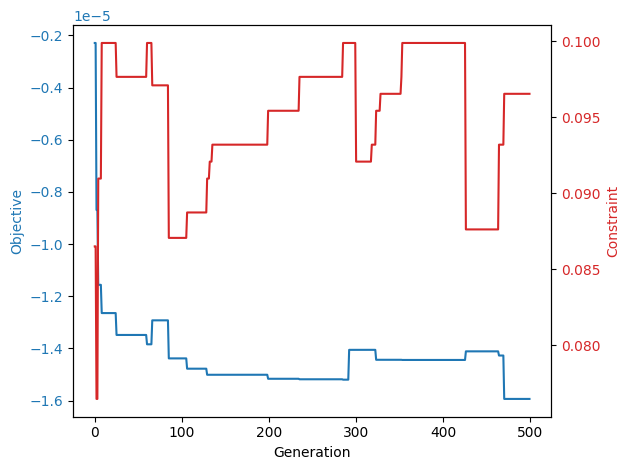

In [ ]:
import matplotlib.pyplot as plt 

fig, ax1 = plt.subplots(); color = 'tab:blue'
ax1.plot(test.bestObj, color = color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('Generation'); ax1.set_ylabel("Objective", color = color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Constraint", color=color)
ax2.plot(test.bestConst, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.show()